# A guide to interactive maps using Bokeh 

Data visualization is key when doing data science. What would be data without an intuitive way to communicate them? 

In this article I will show you how you can create an interactive map using the Bokeh library. The data used here are from the Netherlands and this map is part of the descriptive statistics of a larger analysis. Interactive maps are a great way of letting the user experiment with the data or simply describing many facets of a dataset in one snapshot.

Enough chit-chat, let's jump into action. 

In [1]:
import pandas as pd 
import numpy as np 
import math
import geopandas as gpd
import json 

We import all relevant libraries. In particular `geopandas` will help us managing spatial data, while `json` will be used to convert to json format this data before feeding it to the plot. 

Next we upload the data and read them into a dataset with the pandas method `read_csv`.

In [2]:
your_path="path_to_data_directory"
df=pd.read_csv(your_path+'data.csv',)

In [3]:
df.shape

(4778, 12)

We have 12 columns and 4778 rows, given by data for 3 digit postcode per 6 years.

In [4]:
df.head()

postcode  year        age  number_citizens  \
0       0.0  2011  44.547486       278.189944   
1       0.0  2012  44.391061       267.284916   
2       0.0  2013  44.500000       271.316667   
3       0.0  2014  44.324022       270.290503   
4       0.0  2015  44.346369       264.837989   

   health_expenditure_under_deductible  costs_per_head  log_costs_per_head  \
0                        774429.500279     2095.387356            7.390531   
1                        725115.822346     2074.610201            7.378882   
2                        740548.058167     2154.033235            7.453819   
3                        801208.544749     2375.233188            7.526003   
4                        743374.761508     2249.894004            7.454290   

   wa_statusscore  wa_SHI  status  i rank  pc3  
0             NaN     NaN     NaN     NaN    0  
1             NaN     NaN     NaN     NaN    0  
2             NaN     NaN     NaN     NaN    0  
3             NaN     NaN     NaN     NaN    0  
4             NaN     NaN     NaN     NaN    0

The dataset describes healthcare expenditures and some demographics at the 3 digits postcode level (pc3). The starting data are open access and can be downloaded from [Vektis website](https://www.vektis.nl/open-data#contact). The dataset used here is built on those data by adding information from [CBS](https://www.cbs.nl/en-gb) and it is part of a broader project. Feel free to email me if you want information on how to recreate this dataset starting from the original ones. 

Otherwise, you can downloaded the `df` dataset directly from [here](https://www.dropbox.com/s/7rfanin0l3mn9em/data.csv?dl=0).

### Geodata

First of all let us import postal code coordinates data for the Netherlands. Data was obtained from [GeoNames](http://download.geonames.org/export/zip/). Next, we will merge this data with our dataset, to assign to each postcode data point its geographical coordinate. Note that this coordinates are a point object in [shapely](https://shapely.readthedocs.io/en/latest/). Once a pandas dataset contains a column of spatial data, [geopandas](https://geopandas.org/index.html) needs to be used to handle it. 
A GeoSeries is essentially a vector where each entry in the vector is a set of shapes corresponding to one observation. An entry may consist of only one shape (like a single polygon) or multiple shapes that are meant to be thought of as one observation (like the many polygons that make up one country). In our case, the vector with information on the coordinates of each postcode is a GeoSeries of single shapes, namely points. 

A GeoDataFrame is a tabular data structure that contains a GeoSeries. The most important property of a GeoDataFrame is that it always has one GeoSeries column that holds a special status. This GeoSeries is referred to as the GeoDataFrame’s “geometry”. When a spatial method is applied to a GeoDataFrame, this commands will always act on the “geometry” column.

In [5]:
coordinates = pd.read_csv(your_path+'NL_Full.txt', sep="\t", header=None) #import coordinates of each postcode

In [6]:
columns=["country code", "postal code", "place name","admin name1","admin code1","admin name2","admin code2","admin name3","admin code3",
                       "latitude","longitude","accuracy"]
coordinates.columns=columns #add name to columns

In [7]:
keep=["place name","postal code","latitude","longitude"]
coordinates=coordinates[keep] #keep a selection of the columns 

In [8]:
coordinates.head()

place name postal code  latitude  longitude
0      Assen     9401 AB   52.9984     6.5661
1      Assen     9401 AC   52.9989     6.5687
2      Assen     9401 AD   52.9982     6.5659
3      Assen     9401 AE   52.9981     6.5669
4      Assen     9401 AG   52.9976     6.5684

Now that we have successfully imported the data on the spatial coordinates, in order to match this information with our main dataset  `panel_dataset.csv` we need to average at the 3 digits postal code level. But first I need to generate a new column containing the 3 digits postal code.

In [9]:
coordinates["pc3"]= [ i[0:3] for i in coordinates["postal code"]]
coordinates["pc3"]= coordinates["pc3"].astype('int')

In the code above I've created a new column named `pc3` for the `coordinates` dataset. This was done by selecting the first 3 characters of every string in the column `postal code` using a list comprehension. Then I've proceed to transform the column from `string` into `int` datatype. 

Following [this post](https://stackoverflow.com/questions/6671183/calculate-the-center-point-of-multiple-latitude-longitude-coordinate-pairs) I proceed to calculate the centroid coordinate for each pc3. This will create two new columns: `pc3_lon` and `pc3_lat`; which are respectively the longitude and latitude coordinates of the center of each 3 digit postcode.

In [10]:
#Convert lat/lon (must be in radians) to Cartesian coordinates for each location.
lat=coordinates['latitude']*np.pi/180
lon=coordinates['longitude']*np.pi/180
coordinates["X"] = np.cos(lat) * np.cos(lon)
coordinates["Y"] = np.cos(lat) * np.sin(lon)
coordinates["Z"] = np.sin(lat)

#Compute average x, y and z coordinates.
avg=coordinates.groupby(['pc3']).mean()

x = np.array(coordinates.groupby(['pc3'])['X'].mean())
y = np.array(coordinates.groupby(['pc3'])['Y'].mean())
z = np.array(coordinates.groupby(['pc3'])['Z'].mean())

#Convert average x, y, z coordinate to latitude and longitude.
avg['pc3_lon'] = [math.atan2(y[i], x[i]) for i in range(len(x))]
hyp = np.sqrt(x * x + y * y)
avg['pc3_lat'] = [math.atan2(z[i], hyp[i])*180/np.pi for i in range(len(x))]
avg['pc3_lon']=avg['pc3_lon']*180/np.pi

In [11]:
pc3_coord=avg.reset_index()[["pc3","pc3_lon","pc3_lat"]]
pc3_coord.rename(columns={"pc3": 'postcode' });

We can now proceed to merge the two datasets using the method `.merge` and `pc3` as key. This way the new dataset `df_coor` will be our main data `df` containing additional information on coordinates of each row entry.

In [12]:
df["pc3"]=df.postcode.astype('int') #change data type to 'int' for merging

In [13]:
df_coor=df.merge(pc3_coord,how='left',on="pc3" )

In [14]:
df_coor=df_coor.dropna(subset=['pc3_lon','pc3_lat']) #drop observations without spatial data

In [15]:
#convert dataframe to geodataframe
geodata=gpd.GeoDataFrame(df_coor, geometry=gpd.points_from_xy(df_coor.pc3_lon, df_coor.pc3_lat)) 

In the cell above we have converted our data to geodata. This is done by calling `.GeoDataFrame` and passing as geometry column the points formed by the coordinates. In fact, `points_from_xy` converts the arrays of longitude and latitude into a shapely Point object. 

We have now merged the data and transformed the dataset into a geopandas one. The next step is importing the data for the map of the Netherlands and plotting the information by postcode. The Netherlands municipalities' map can be imported into Python directly from the CBS website [(cartography)](https://www.cbs.nl/en-gb/our-services/open-data/statline-as-open-data/cartography). 

In [16]:
# Retrieve data with municipal boundaries from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
municipal_boundaries = gpd.read_file(geodata_url)

In [17]:
municipal_boundaries=municipal_boundaries[["statnaam","geometry"]] #keep only name and geometry

municipal_boundaries.head()

statnaam                                           geometry
0    Appingedam  POLYGON ((254580.6743 594573.5057, 254695.9458...
1         Bedum  POLYGON ((235432.131 595115.6255, 235465.6951 ...
2  Bellingwedde  POLYGON ((276518.0677 566843.1256, 276821.544 ...
3      Ten Boer  POLYGON ((245194.6907 592594.0072, 245329.01 5...
4      Delfzijl  POLYGON ((262016.5555 587782.3094, 259448.59 5...

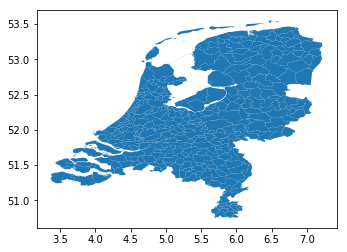

In [27]:
municipal_boundaries.plot()

Great, this is definitly the Netherlands! Looking at the axis we can notice that the coordinate are in a different reference system. Let's change that. 

We can then plot the country's map along with the data points of  to get a first impresion. 

We change coordinate reference system for it to be in longitude and latitude and we plot the map with the data points from `geodata` to get a first impresion. 

In [19]:
municipal_boundaries.to_crs(epsg= "4326",inplace=1) #change coordinate reference system

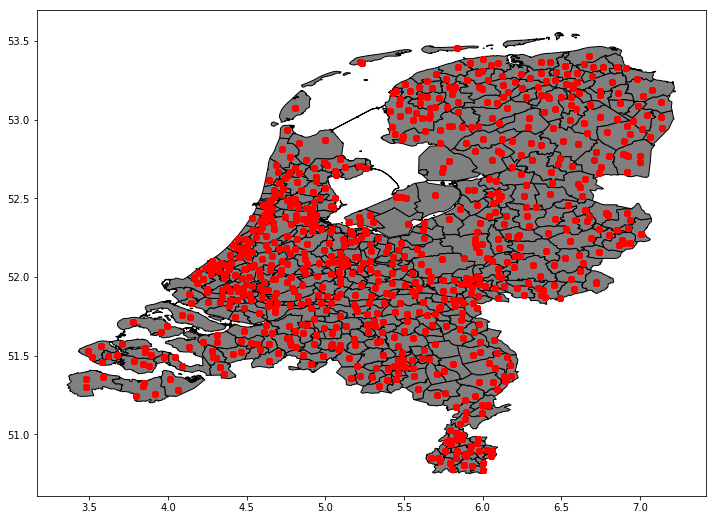

In [20]:
base=municipal_boundaries.plot(figsize=(12,9),color='grey', edgecolor='black')
geodata.plot(ax=base,color='red') 

Well it's a bit chaotic but it works! 

You have probably noticed that most of the municipalities have multiple datapoints in them. That's because most municipality have multiple 3 digit postcodes. In the interactive map we will show information of each postcode when hovering over every municipality. How? 

Let's take plotting to the next level with the Bokeh library.

## Bokeh interactive map

We are finally ready to join the datasets using the geopandas method `sjoin` based on the pc3 coordinates being contained in the polygons representing the municipality boundaries.

In [21]:
mun=gpd.sjoin(municipal_boundaries,geodata,how="left", op='contains')

C:\Users\Mr Nobody\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326', 'no_defs': True} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


Here we are, ready to plot the interactive map using [Bokeh](https://docs.bokeh.org/en/latest/docs/user_guide.html) library. Another valid option for plotting geomaps would be [Folium](https://python-visualization.github.io/folium/index.html).

In [22]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer 
from bokeh.io import curdoc, output_notebook
from bokeh.models import Slider, HoverTool
from bokeh.layouts import widgetbox, row, column

Before plotting we need to convert the data in json format because that's the one used by bokeh to plot spatial data. First, we select the most recent year which in this case is 2016.

In [23]:
data=mun[mun['year']==2016] #select a single year

In [24]:
nl_data_json = json.loads(data.to_json())
json_data = json.dumps(nl_data_json)

We now want the map to update as we change the year. To do so we need to set up a so called 'callback function'. Before that, we want to create a function that puts the data for a given year in the correct json format to be plotted. This is done in the first few lines. 

The color mapper is a function that maps values in a certain interval to a color palette. This is what makes our map colorful!

The 'hover' tool will allow us to show some information when dragging the cursor over a municipality.

The 'slider' will allow us to shift among different years. A slider alone is just a graphical element, the real magic is done by the callback function. This function tells what should be changed when the position of the slider changes. The two are linked by the `on_click` method. Lastly the `curdoc` and `layout` defined at the very bottom concern the creation of a document instance collecting Bokeh models (e.g. plots, layouts, widgets, etc.) so that they may be reflected into the BokehJS client runtime. In simple words, is the part that puts it all together and ready to be ran in a Bokeh server. 

In [25]:
#Define function that returns json_data for year selected by user.
    
def json_data(selectedYear):
    data=mun[mun['year']==selectedYear]
    nl_data_json = json.loads(data.to_json())
    json_data = json.dumps(nl_data_json)
    return json_data

#Input GeoJSON source that contains features for plotting.We select 2016 as the first year to show
geosource = GeoJSONDataSource(geojson = json_data(2016))

#Define the color palette.
palette = brewer['YlOrRd'][8]

#Reverse color order so that dark red is the highest health expenditure.
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 880, high = 3000, nan_color = '#d9d9d9')

#Add hover tool
hover = HoverTool(tooltips = [ ('Postcode','@postcode'),('Health Expenditure per cap.', '@costs_per_head'),('Average age'
                                ,'@age'),('Household income','@wa_SHI'),('Socio economic status','@status')])


#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 400, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')


#Create figure object.
p = figure(title = 'Health expenditure per capita in the Netherlands, 2016', plot_height = 600 , plot_width = 800)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.add_tools(hover)
p.title.text_font_size= '16pt'
p.title.align='center'

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'costs_per_head', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)


p.add_layout(color_bar, 'below')

# Define the callback function: update_plot
def update_plot(attr, old, new):
    yr = slider.value
    new_data = json_data(yr)
    geosource.geojson = new_data
    p.title.text = 'Health expenditure per capita in the Netherlands,%d' %yr
    
# Make a slider object: slider 
slider = Slider(title = 'Year',start =2011 , end = 2016, step = 1, value = 2016)
slider.on_change('value', update_plot)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
layout = column(p,widgetbox(slider))
curdoc().add_root(layout)

#Display plot inline in Jupyter notebook
output_notebook()

#Display plot
show(layout)

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



As explained in the warning, to run the plot properly with the functioning slider we need to call a Bokeh Server. To learn more about how this works you can check out the section ['Running a BokehServer'](https://docs.bokeh.org/en/latest/docs/user_guide/server.html) of the user manual. If you can't wait to see it in action, just open the command window or Anaconda prompt in your current directory and type `bokeh serve --filename.ipynb`. Make sure you have Bokeh installed ( using `pip install bokeh` or if using Anaconda `conda install bokeh`). This should do the job!

I hope you had fun learning how to make an interactive map in Python. As you can see possibilities are endless and there's always something new to learn when programming. Of course every suggestion is welcome and let me know if you were able to replicate the interactive map yourself!

In [26]:
print('Ad maiora!')

Ad maiora!
